In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Transfer learning

This notebook shows you how to perform transfer learning  with ``AUCMEDI``.  

__Notes on transfer learning:__
* The goal of transferlearning is to use pretrained models on another classification task.
* Since the pretrained models were pretrained on a different but very large image-set (mostly Imagenet) their trained weights won't fit perfectly for the task at hand (the closer the better).
* The weights of the pretained models are most likely still better than an untrained model (random weights).
* Therefore the pretrained model can be used.
* The weights of the pretrained model of all layers but the classification head are then frozen during training of the new task.
* This is done, because if the weights wouldn't be frozen they would be "deleted" by the first epoch of training.
* The classification-head, however, can't be frozen, because it needs to be adapted to the new task.
* After some epochs of training the freezing is undone, so that the weights can be adapted to the new task.
* With transfer-leaning models can be trained even when fewer data/images are available.
* Furthermore time is saved, because the weights are preinitialized.

## Downloading and preparing the data

First, the data need to be loaded and prepared for ``AUCMEDI``.  
If you have questions concering that part, just have a look in the corresponding notebook.

In [2]:
from pathlib import Path
import wget
import zipfile

cwd = !pwd
datadir = cwd[0] + "/data"
Path(datadir).mkdir(parents=True, exist_ok=True)

#print('Beginning file download with wget module')

#url = 'https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1'
#wget.download(url, datadir)

#with zipfile.ZipFile("data/Kather_texture_2016_image_tiles_5000.zip","r") as zip_ref:
#    zip_ref.extractall("data")

from aucmedi.data_processing.io_data import input_interface
ds_loader = input_interface("directory", path_imagedir="data/Kather_texture_2016_image_tiles_5000", path_data=None, training=True, ohe=False)
(samples, class_ohe, nclasses, class_names, image_format) = ds_loader

from aucmedi.sampling.split import sampling_split
train, validation, test = sampling_split(samples, class_ohe, sampling=[0.5, 0.25, 0.25], 
                                         stratified=True, iterative=False, seed=123)

2022-07-19 12:33:47.317256: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Performing Transfer learning

Let's define our transfer learning model:  
* We are using ``ResNet50`` as architecture, because for ``ResNet50`` there are pretrained weights from ``ImageNet`` available. Of course other architectures that provide pretrained weights would be feasible as well.
* The argument ``pretrained_weights`` is set to ``True``, to tell ``AUCMEDI`` to use these weights.

In [3]:
from aucmedi.neural_network.model import NeuralNetwork
import tensorflow_addons as tfa

f1Score = tfa.metrics.F1Score(num_classes=nclasses, threshold=0.5)


transferlearning_model = NeuralNetwork(n_labels=nclasses, channels=3, architecture="2D.ResNet50", 
                      loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], 
                      activation_output="softmax", pretrained_weights=True)

2022-07-19 12:33:50.283896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-19 12:33:50.886536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22844 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:40:00.0, compute capability: 7.5


The ``DataGenerator``s are setup as usual.  

However, during training, the argument ``transfer_learning`` is set to ``True``, to tell ``AUCMEDI`` to perform transfer learning. This means, that the pretrained weights are frozen in the base-model (here ``ResNet``) for the first 10 epochs.  
This is done to avoid destroying any of the information they contain the training rounds.  
After that fine-tuning is performed for the remaining epochs. This means, that the entire model unfrozen and with a very low learning rate.  

You don't have to  setup this yourself, ``AUCMEDI`` takes care of the freezing and unfreezing for you. Just set the ``transfer_learning`` argument to ``True``.

In [4]:
from aucmedi.data_processing.data_generator import DataGenerator

train_generator = DataGenerator(samples=train[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                               resize=transferlearning_model.meta_input, standardize_mode=transferlearning_model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=None, 
                                               grayscale=False, subfunctions=[], prepare_images=False, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                             resize=transferlearning_model.meta_input, standardize_mode=transferlearning_model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=False, 
                                             sample_weights=None, seed=123, workers=1)

history = transferlearning_model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=None, class_weights=None, transfer_learning=True)

Epoch 1/10


2022-07-19 12:33:56.107683: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-19 12:33:56.682073: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


79/79 [==============================] - 18s 168ms/step - loss: 0.9294 - categorical_accuracy: 0.6884 - f1_score: 0.6844 - val_loss: 0.3771 - val_categorical_accuracy: 0.8808 - val_f1_score: 0.8760
Epoch 2/10
79/79 [==============================] - 12s 155ms/step - loss: 0.4166 - categorical_accuracy: 0.8588 - f1_score: 0.8580 - val_loss: 0.3005 - val_categorical_accuracy: 0.9008 - val_f1_score: 0.8973
Epoch 3/10
79/79 [==============================] - 13s 161ms/step - loss: 0.3201 - categorical_accuracy: 0.8928 - f1_score: 0.8915 - val_loss: 0.2795 - val_categorical_accuracy: 0.9184 - val_f1_score: 0.9118
Epoch 4/10
79/79 [==============================] - 12s 152ms/step - loss: 0.2511 - categorical_accuracy: 0.9092 - f1_score: 0.9088 - val_loss: 0.2554 - val_categorical_accuracy: 0.9160 - val_f1_score: 0.9177
Epoch 5/10
79/79 [==============================] - 14s 171ms/step - loss: 0.2147 - categorical_accuracy: 0.9264 - f1_score: 0.9254 - val_loss: 0.2381 - val_categorical_accura

Lets have a look at the training history:

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.loss.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

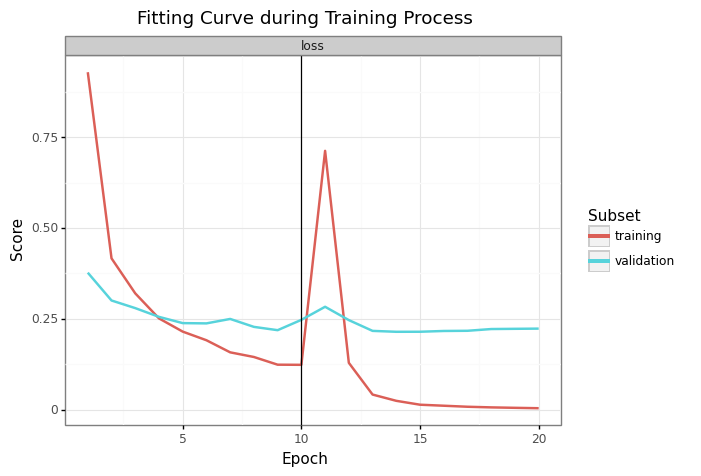

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.accuracy.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

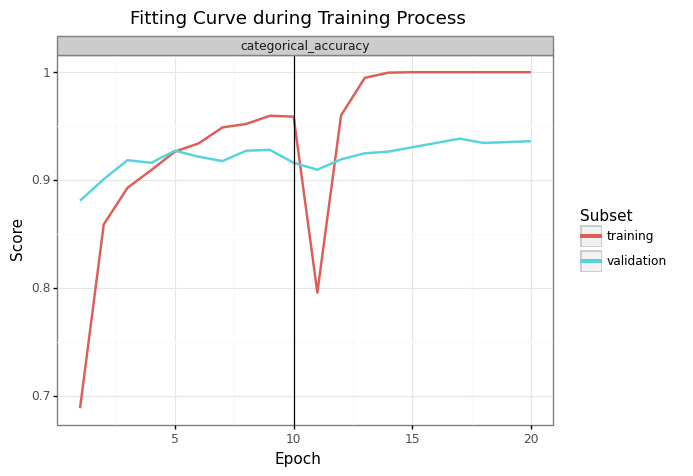

In [5]:
from aucmedi import *
from aucmedi.evaluation.fitting import *

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["loss"],
    prefix_split=".",
    suffix="loss",
    show=True
)

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["accuracy"],
    prefix_split=".",
    suffix="accuracy",
    show=True
)

The vertical bar indicates epochs with frozen weights (left site of the bar, epochs 1 to 10) and epochs that were the weights were finetuned (here epochs 11 to 20).  

After unfreezing the weights (in epoch 11) the training accuracy goes down and the loss up at first, because the correct weights have to be found first. (Remember that we previously used the weights that were trained on a different task, so now they have to be adapted to the classification task at hand.)

For the validation accuracy and loss the drop/increase is not so obvious, because it is calculated differently: While tensorflow calculates the metrics for the training set for each epoch, a mean of all previous epochs is calculated for the validation-test.

## But what's transfer learning good for?

But why would you use transfer learning in the first place? After all, transfer learning means that you are using weights that have been obtainted via training a model on a different data source, not the one you are interested in (f.e. ``ImageNet``).  
I turns out, that using these weights is often better than using random weights. With transfer learning you can use the knowledge a model "obtained" by being trained on a differend source rather than starting from zero.  

So let us compare the transfer learning model to a model where we don't apply transfer learning.

In [6]:
from aucmedi.neural_network.model import NeuralNetwork
import tensorflow_addons as tfa

f1Score = tfa.metrics.F1Score(num_classes=nclasses, threshold=0.5)


no_transferlearning_model = NeuralNetwork(n_labels=nclasses, channels=3, architecture="2D.ResNet50", 
                      loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], 
                      activation_output="softmax", pretrained_weights=False)

### Train the model

Now we are training our "transfer-learning free" model...

In [7]:
from aucmedi.data_processing.data_generator import DataGenerator

train_generator = DataGenerator(samples=train[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                               resize=no_transferlearning_model.meta_input, standardize_mode=no_transferlearning_model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=None, 
                                               grayscale=False, subfunctions=[], prepare_images=False, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                             resize=no_transferlearning_model.meta_input, standardize_mode=no_transferlearning_model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=False, 
                                             sample_weights=None, seed=123, workers=1)

history = no_transferlearning_model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=None, class_weights=None, transfer_learning=False)

Epoch 1/20
79/79 [==============================] - 22s 224ms/step - loss: 1.9453 - categorical_accuracy: 0.4520 - f1_score: 0.4268 - val_loss: 3.0580 - val_categorical_accuracy: 0.1256 - val_f1_score: 0.0279
Epoch 2/20
79/79 [==============================] - 18s 227ms/step - loss: 1.3449 - categorical_accuracy: 0.5796 - f1_score: 0.5616 - val_loss: 3.5568 - val_categorical_accuracy: 0.1248 - val_f1_score: 0.0313
Epoch 3/20
79/79 [==============================] - 18s 227ms/step - loss: 1.0531 - categorical_accuracy: 0.6616 - f1_score: 0.6433 - val_loss: 3.3606 - val_categorical_accuracy: 0.1600 - val_f1_score: 0.0746
Epoch 4/20
79/79 [==============================] - 18s 229ms/step - loss: 0.9226 - categorical_accuracy: 0.6952 - f1_score: 0.6844 - val_loss: 1.8245 - val_categorical_accuracy: 0.4376 - val_f1_score: 0.3629
Epoch 5/20
79/79 [==============================] - 17s 218ms/step - loss: 0.8994 - categorical_accuracy: 0.7088 - f1_score: 0.7007 - val_loss: 1.8784 - val_categor

## Comparison of the two models

Let's compare the two models - the model were we applied transfer learning (called ``transferlearning_model`` here) and the one without transfer learning (named ``no_transferlearning_model`` here).

Both models are evaluated on the test-data.  
We are interested in the predictions both models perform on these data.

In [10]:
from aucmedi.data_processing import data_generator

predict_generator = data_generator.DataGenerator(samples=test[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                                 resize=no_transferlearning_model.meta_input, standardize_mode=no_transferlearning_model.meta_standardize,
                                                 labels=None, image_format=image_format, batch_size=32, data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)



We can use the same ``DataGenerator`` for both models (the ``transferleaning_model`` and the ``no_transferlearning_model``), because the ``DataGenerator`` is just used to create batches. Since we evaluate both models on the same data/same batches the same ``DataGenerator`` is fine.

The prediction of course needs to be done for each model seperately. We want to compare the goodness of the predictions.

In [11]:
prediction_of_no_transferlearning_model = no_transferlearning_model.predict(prediction_generator=predict_generator)
prediction_of_transfer_model = transferlearning_model.predict(prediction_generator=predict_generator)

40/40 [==============================] - 4s 85ms/step


To compare the predictions we use the comparison function, ``AUCMEDI`` provides:

In [12]:
from aucmedi import *
from aucmedi.evaluation.comparison import *

pred_ensemble = [prediction_of_no_transferlearning_model, prediction_of_transfer_model]

evaluate_comparison(pred_ensemble, test[1], out_path="./", class_names=class_names, model_names=["no_transferlearning", "transferlearning"], macro_average_classes=True)

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/metrics.py:73: RuntimeWarning: invalid value encountered in true_divide
/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/metrics.py:76: RuntimeWarning: invalid value encountered in true_divide
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 18 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.comparison.beside.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 18 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.comparison.gain.png
/home/main/.local/lib/python3.8/site-packages/plotni

(         metric                model        score
 0           AUC  no_transferlearning     0.499881
 1      Accuracy  no_transferlearning     0.928200
 2            F1  no_transferlearning     0.672170
 3           FDR  no_transferlearning     0.238014
 4            FN  no_transferlearning    44.875000
 5           FNR  no_transferlearning     0.286583
 6            FP  no_transferlearning    44.875000
 7           FPR  no_transferlearning     0.041019
 8     Precision  no_transferlearning     0.761986
 9   Sensitivity  no_transferlearning     0.713417
 10  Specificity  no_transferlearning     0.958981
 11           TN  no_transferlearning  1048.875000
 12           TP  no_transferlearning   111.375000
 13          AUC     transferlearning     0.499949
 14     Accuracy     transferlearning     0.981600
 15           F1     transferlearning     0.926757
 16          FDR     transferlearning     0.072507
 17           FN     transferlearning    11.500000
 18          FNR     transferle

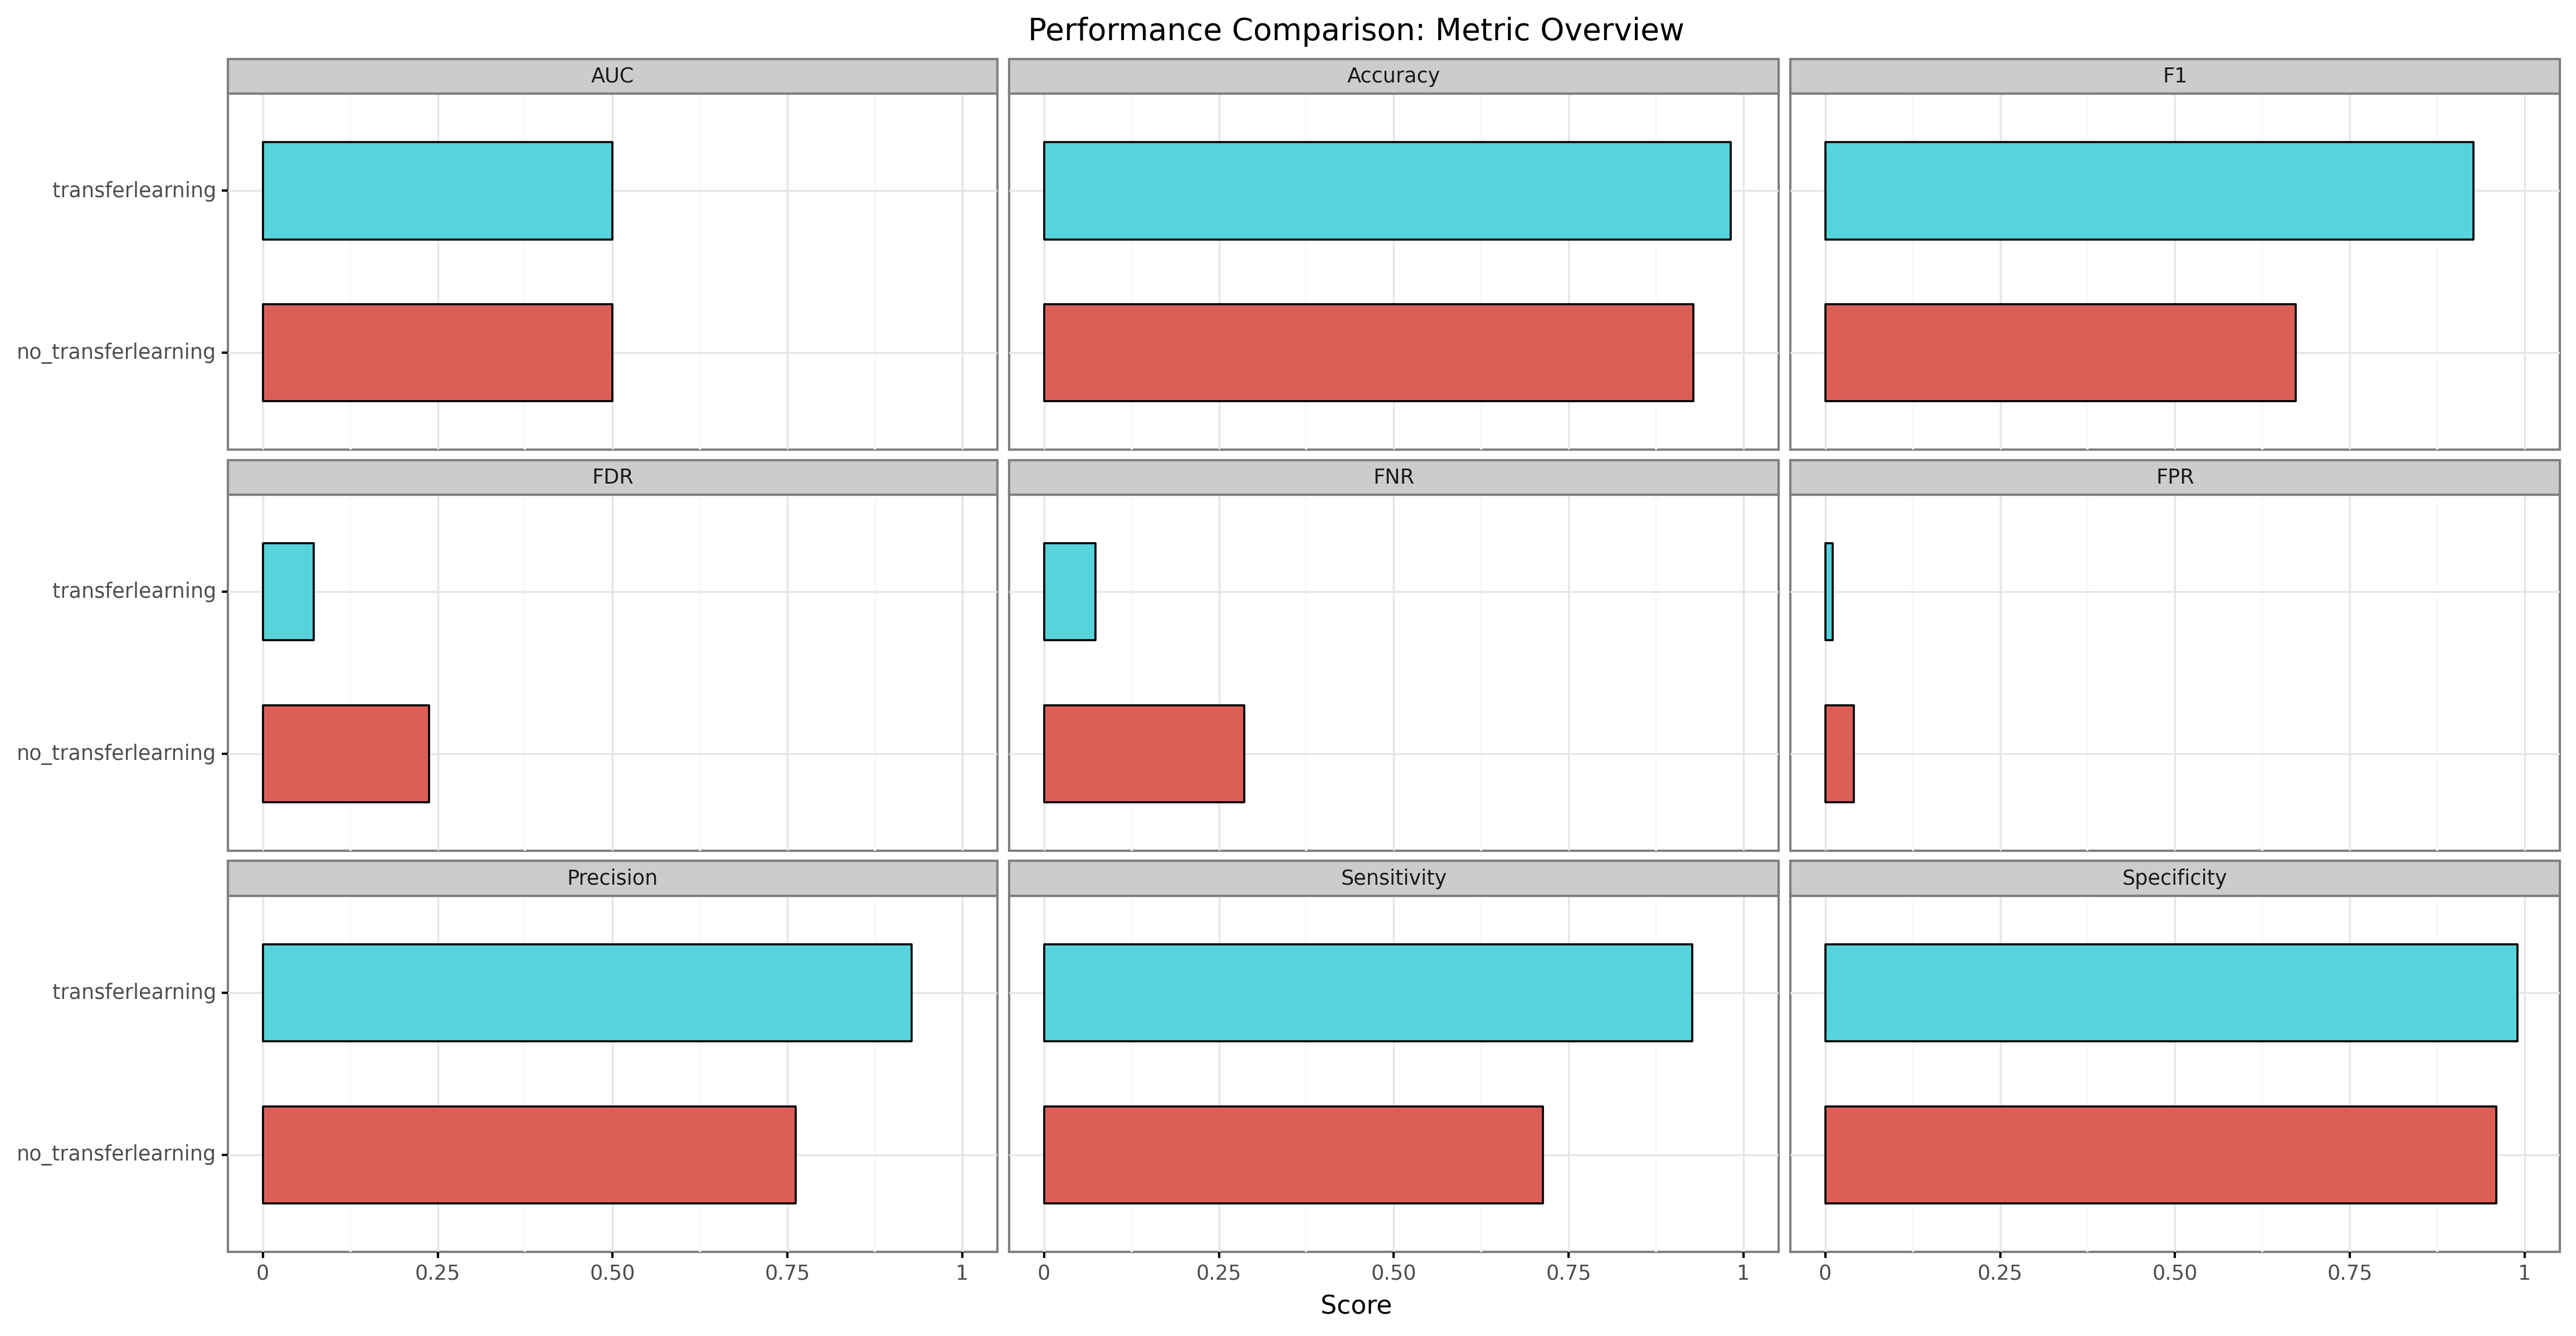

In [13]:
from PIL import Image
img = Image.open("plot.comparison.beside.png")
img.show()

As we can see, the transfer learning model is better in (almost) all regards (only the AUC seems to be about equal).

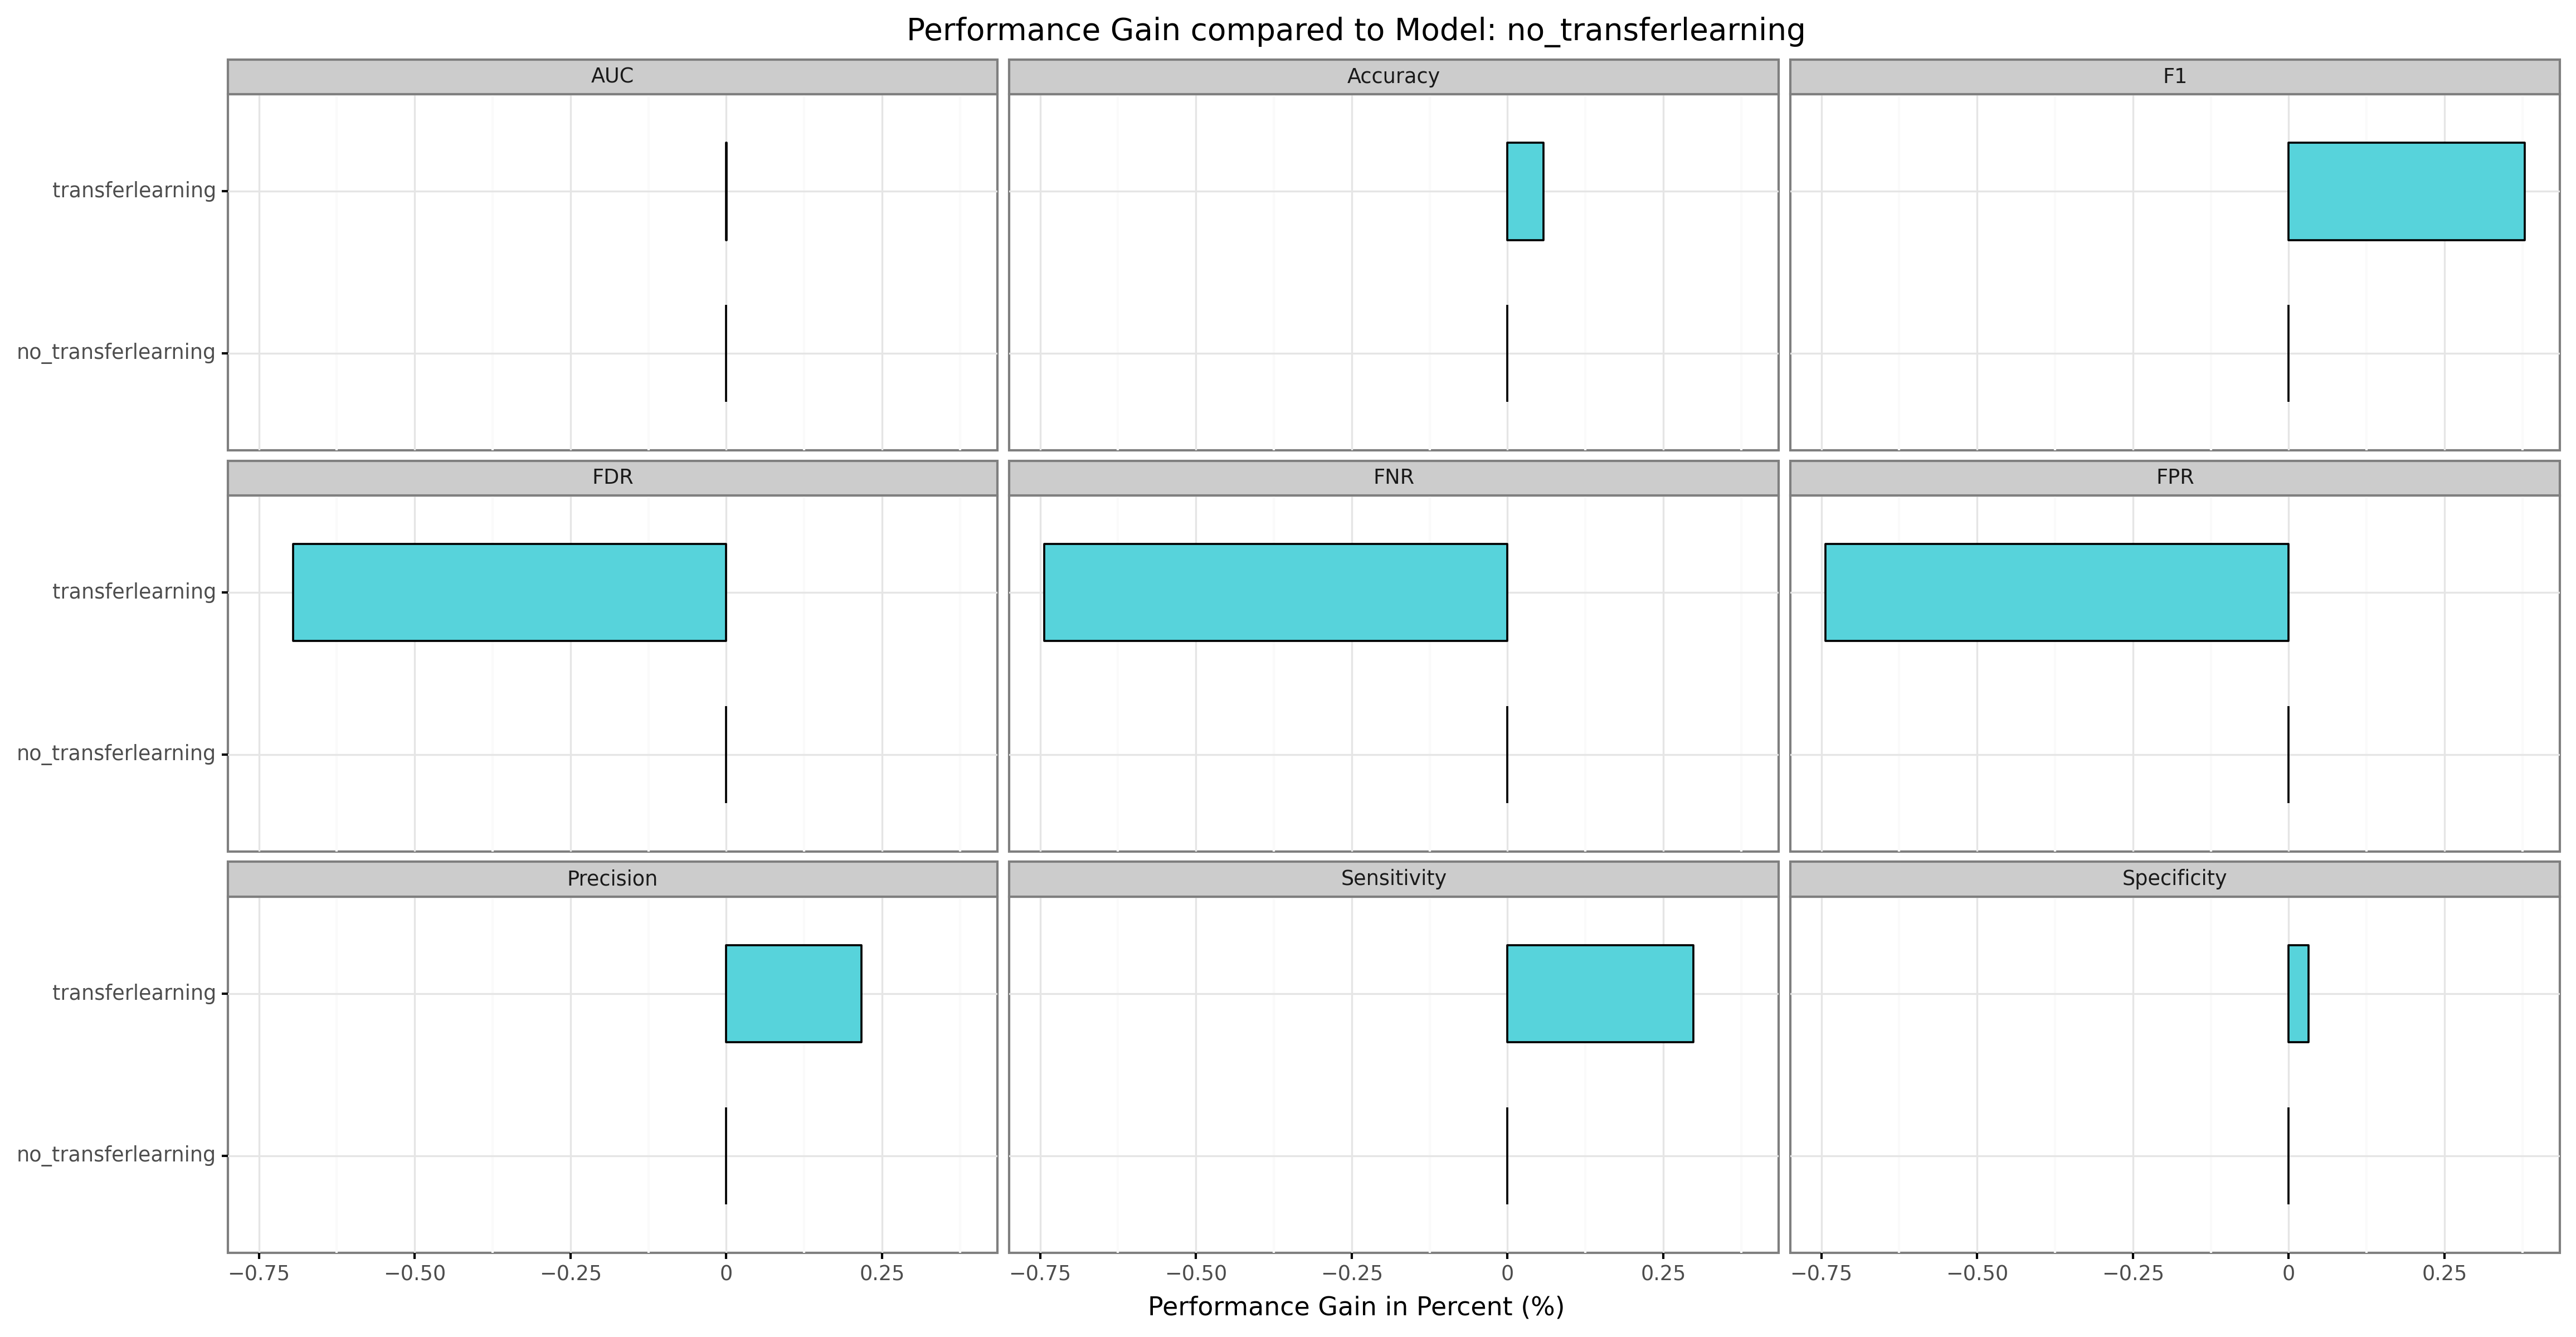

In [14]:
from PIL import Image
img = Image.open("plot.comparison.gain.png")
img.show()

The gain-plot shows the same information as performance gains in percent. Here we can also see pretty clearly that transfer learning helped to reduce the false discovery rate (FDR), false negative rate (FNR) and false positive rate (FPR), but increased precision, sensitivity and specificity as well as accuracy and F1. Only for the AUC the results aren't so clear.